In [7]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [9]:
#read data 
data = pd.read_csv('./data/age_gender.csv')

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [12]:
## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()



AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [13]:
data.shape

(23705, 5)

In [14]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [16]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

In [17]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')


In [18]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')


In [20]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

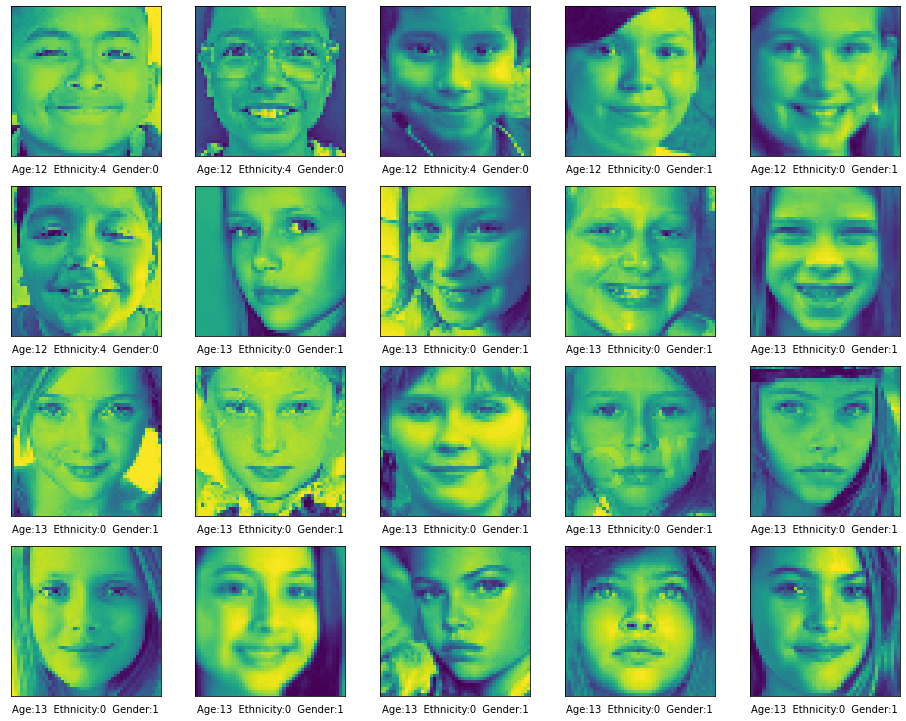

In [21]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

# Model for Gender Prediction

In [23]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=37)

In [24]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

In [25]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 23s 88ms/step - loss: 0.5031 - accuracy: 0.7552 - val_loss: 0.5807 - val_accuracy: 0.8140
Epoch 2/20
260/260 [==============================] - 24s 92ms/step - loss: 0.3848 - accuracy: 0.8291 - val_loss: 0.4007 - val_accuracy: 0.8410
Epoch 3/20
260/260 [==============================] - 23s 89ms/step - loss: 0.3449 - accuracy: 0.8474 - val_loss: 0.3192 - val_accuracy: 0.8621
Epoch 4/20
260/260 [==============================] - 23s 87ms/step - loss: 0.3210 - accuracy: 0.8612 - val_loss: 0.3165 - val_accuracy: 0.8610
Epoch 5/20
260/260 [==============================] - 22s 86ms/step - loss: 0.3057 - accuracy: 0.8683 - val_loss: 0.2970 - val_accuracy: 0.8648
Epoch 6/20
260/260 [==============================] - 24s 92ms/step - loss: 0.2902 - accuracy: 0.8742 - val_loss: 0.2930 - val_accuracy: 0.8702
Epoch 7/20
260/260 [==============================] - 23s 90ms/step - loss: 0.2806 - accuracy: 0.8767 - val_loss: 0.3031 - val_accuracy:

In [26]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [27]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

In [28]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [29]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/16
260/260 [==============================] - 17s 63ms/step - loss: 1.2160 - accuracy: 0.5389 - val_loss: 0.9063 - val_accuracy: 0.6912
Epoch 2/16
260/260 [==============================] - 16s 62ms/step - loss: 0.9546 - accuracy: 0.6669 - val_loss: 0.8042 - val_accuracy: 0.7193
Epoch 3/16
260/260 [==============================] - 16s 61ms/step - loss: 0.8622 - accuracy: 0.7014 - val_loss: 0.7318 - val_accuracy: 0.7469
Epoch 4/16
260/260 [==============================] - 16s 61ms/step - loss: 0.8098 - accuracy: 0.7198 - val_loss: 0.6934 - val_accuracy: 0.7680
Epoch 5/16
260/260 [==============================] - 16s 62ms/step - loss: 0.7594 - accuracy: 0.7389 - val_loss: 0.6496 - val_accuracy: 0.7745
Epoch 6/16
260/260 [==============================] - 17s 64ms/step - loss: 0.7283 - accuracy: 0.7489 - val_loss: 0.6347 - val_accuracy: 0.7831
Epoch 7/16
260/260 [==============================] - 16s 63ms/step - loss: 0.6974 - accuracy: 0.7592 - val_loss: 0.6511 - val_accuracy:

In [30]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6175140142440796
Test Accuracy: 0.7921779155731201


# Model for Age prediction

In [31]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

In [32]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                      

In [33]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 25s 94ms/step - loss: 341.9654 - mae: 14.0103 - val_loss: 1175.4067 - val_mae: 28.6087
Epoch 2/20
260/260 [==============================] - 24s 92ms/step - loss: 205.3702 - mae: 10.7397 - val_loss: 551.7660 - val_mae: 18.2066
Epoch 3/20
260/260 [==============================] - 24s 93ms/step - loss: 174.7189 - mae: 9.9114 - val_loss: 131.6010 - val_mae: 8.2681
Epoch 4/20
260/260 [==============================] - 26s 99ms/step - loss: 159.7134 - mae: 9.3592 - val_loss: 122.1508 - val_mae: 7.9763
Epoch 5/20
260/260 [==============================] - 25s 96ms/step - loss: 146.5376 - mae: 8.9536 - val_loss: 121.8935 - val_mae: 7.9481
Epoch 6/20
260/260 [==============================] - 25s 96ms/step - loss: 135.2654 - mae: 8.5751 - val_loss: 110.1596 - val_mae: 7.9529
Epoch 7/20
260/260 [==============================] - 25s 95ms/step - loss: 127.7545 - mae: 8.3370 - val_loss: 164.1979 - val_mae: 10.3102
Epoch 8/20
260/260 [========

In [34]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 94.64725494384766
Test Mean absolute error: 7.297165393829346


In [40]:
X_train[0]

array([[[0.08235294],
        [0.09803922],
        [0.11764706],
        ...,
        [0.07843138],
        [0.05098039],
        [0.02745098]],

       [[0.04705882],
        [0.05098039],
        [0.05882353],
        ...,
        [0.05490196],
        [0.04313726],
        [0.01960784]],

       [[0.04313726],
        [0.04313726],
        [0.04313726],
        ...,
        [0.03529412],
        [0.03921569],
        [0.02352941]],

       ...,

       [[0.04313726],
        [0.05490196],
        [0.05882353],
        ...,
        [0.03921569],
        [0.02352941],
        [0.03529412]],

       [[0.04705882],
        [0.05490196],
        [0.05882353],
        ...,
        [0.05490196],
        [0.04313726],
        [0.05098039]],

       [[0.04705882],
        [0.05490196],
        [0.05882353],
        ...,
        [0.05882353],
        [0.0627451 ],
        [0.05882353]]], dtype=float32)